In [2]:
#given a dataset for H(z), z, err(H), we do an MCMC analysis and find corner plots for the data

import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
import pandas as pd
from astropy.table import Table
import scipy

In [3]:
#------ BACKGROUND EQUATIONS ------

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

# Equation 2.12
def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    if alpha_tilde == 0:
        ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans

In [4]:
# --- Equations for mu ----

def D_L(z,cosmo,H0):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)

    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    c = 3e5
    D = np.zeros(len(z))
    for i in range(len(z)):
        chi = scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z[i])[0]
        if Omega_k > 0:
            D[i] = (c*(1+z[i])/H0)*np.sinh(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        elif Omega_k < 0:
            D[i] = (c*(1+z[i])/H0)*np.sin(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        else:
            D[i] = (c*(1+z[i])/H0)*chi
    return D

# dl has units of Mpc
def mu(dl):
    return 5*np.log10(dl/1e-5)

In [5]:
def log_likelihood(theta, z, y, cov):
    alpha_t, H0 = theta 
    Omg_r = (2.47e-5*(H0/100)**-2)*1.6949484 # last factor due to neutrinos
    model = np.array(mu(D_L(z, [0.27 , 0 , 0 , Omg_r , alpha_t,0], H0)))
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(cov)),np.transpose(y-model))

In [15]:
def log_prior(theta):
    alpha_t, H0 = theta
    if 0 < alpha_t < 2 and 55 < H0 < 100:
        return 0.0
    return -np.inf

In [16]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [17]:
# get the data

# data values for z_b, mu_b
tab_vals = Table.read(r'~/Desktop/Newcastle/4DEGB/SneTable.tex')

# covariance matrix for our data - NOTE MISS FACTOR OF 10^-6
tab_cov = Table.read(r'/home/c2042999/Desktop/Newcastle/4DEGB/SneTable_covmat.tex')

# get it in matrix form
tab_cov = np.lib.recfunctions.structured_to_unstructured(tab_cov.as_array())
tab_cov = tab_cov.filled(0)
# get the correct symmetric format
tab_cov = 1e-6 * (np.rot90(np.fliplr(tab_cov)) + tab_cov - np.diag(np.diag(tab_cov)))


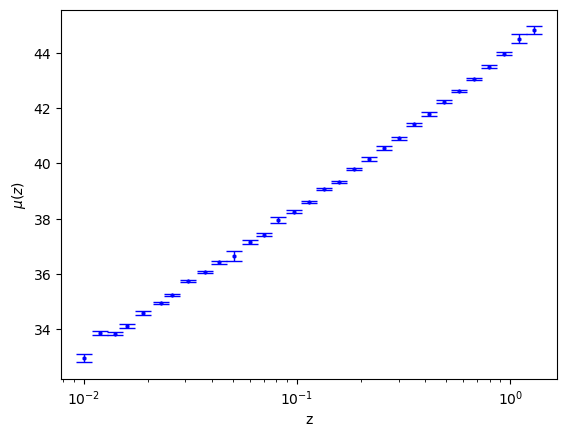

In [18]:
# Choose the seed parameters.
H0_est = 60
alpha_t_est = 0.01

# Plot our data
x = np.array(tab_vals["$z_b$"])
cov = tab_cov
y = np.array(tab_vals["$\mu_b$"])

# 
plt.errorbar(x, y, yerr=np.array(np.sqrt(np.diag(cov))),ls = "none", linewidth=1, capsize=6, color = "b")
plt.scatter(x, y, s = 5, marker = "h", color = "b")

x0 = np.linspace(0, 10, 500)
plt.xlabel("z")
plt.ylabel(r"$\mu(z)$");
plt.xscale("log")

In [19]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
pos = [alpha_t_est , H0_est] + 1e-2 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, cov)
)
sampler.run_mcmc(pos, 1000, progress=True);

  0%|                                                                                        | 0/1000 [00:00<?, ?it/s]/home/c2042999/anaconda3/envs/4DEGB_venv2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:29<00:00,  6.69it/s]


(3000, 2)


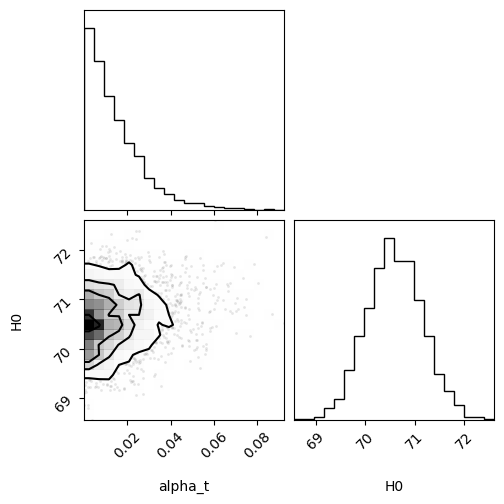

In [20]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["alpha_t", "H0"]
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels
);

50
1000
2
1000


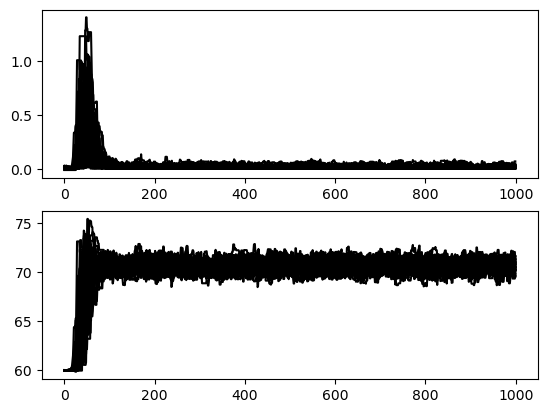

In [21]:
samples_chain = sampler.chain
print(len(samples_chain))
print(len(samples_chain[0]))
print(len(samples_chain[0][0]))
print(len(samples_chain[0, :, 0]))

fig, ax = plt.subplots(2)

for i in range(len(samples_chain)):
    ax[0].plot(samples_chain[i, :, 0], color = "black")
    ax[1].plot(samples_chain[i, :, 1], color = "black")


In [22]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

/tmp/ipykernel_108747/2651702976.py:23: RuntimeWarning: divide by zero encountered in log10
  return 5*np.log10(dl/1e-5)


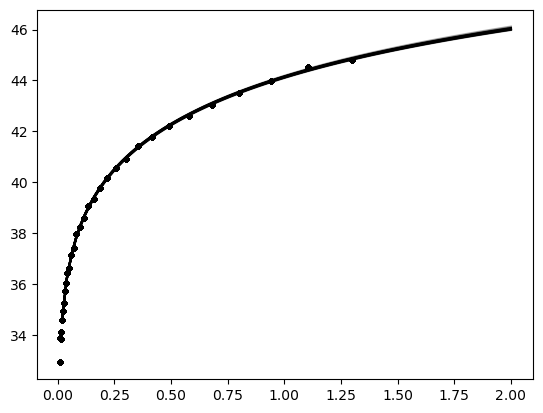

In [23]:
# --- PLOT DATA WITH ESTIMATED PARAMS -----

xl = np.linspace(0,2,int(1e2))
for alpha_t, H0 in flat_samples[np.random.randint(len(flat_samples), size=100)]:
    Omg_r = 2.47e-5*(H0/100)**-2
    Omg_m = 0.27
    plt.plot(xl, np.array(mu(D_L(xl, [Omg_m , 0 , 0 , Omg_r , alpha_t , 0], H0))), color="k", alpha=0.1)
    plt.errorbar(x, y, yerr=np.array(np.diag(cov)), fmt=".k")
